### this we debug consistent ways of dealing with lunar lander type env  
N, K, A: batch_size, discrete space size, action space size  

discrete: policy returns Categorical([N,K]), action [N] 1D int array  
continous: policy returns DiagGaussin([N,A], logstd[A]), action [N,A] 2D float array  
dis-continious: discretized the continuous action space; policy returns Categorical([N,A,K]), action [N,A] 2D int array, log_prob needs one extra sum over axis=-1  

In [45]:
import os
import gym
import matplotlib.pyplot as plt
import numpy as np
os.environ["SDL_VIDEODRIVER"] = "x11"
from IPython import display

env1 = gym.make("LunarLanderContinuous-v2")#, render_mode="human")
env2 = gym.make("LunarLander-v2")#, render_mode="human")

In [2]:
env1.action_space.shape[0]

2

In [3]:
from gym.spaces.discrete import Discrete
from gym.spaces.box import Box

class EnvWrapper():
    '''
      wrapper around env
      for discrete env:
        scale the reward only
      for continuous env:
        1. if make discrete, then make it discrete
        2. if not, scale the input action (-1,1) to proper action space
      implement reset and step
      NOTE: for lunar lander, better to set reward_scale=0.01 to get a lot better convergence
    '''
    def __init__(self, env, reward_scale=1.0, make_discrete=None):
        self.env = env
        self.env.reset()
        self.reward_scale = reward_scale
        if isinstance(env.action_space, Discrete):
            self.type = 'discrete'
            self.K = env.action_space.n
            pass
        else:
            if make_discrete is None:
                self.type = 'continuous'
                lows, highs = env.action_space.low, env.action_space.high
                self.action_space_means = (highs + lows) / 2.0
                self.action_space_stds = (highs - lows) / 2.0
                self.A = env.action_space.shape[0]
            else:
                self.type = 'dis-continuous'
                self.discrete_actions = np.array([np.linspace(low, high, make_discrete) \
                                                  for low, high in zip(env.action_space.low, env.action_space.high)])
                self.K = make_discrete
                self.A = env.action_space.shape[0]                
        
    def reset(self):
        return self.env.reset()
        
    def step(self, action):
        '''
          for discrete: action is int, from range(K)
          for continuous: action is [A], A is the dimension of action_space
          for dis-continuous: action is [A], A is the dimension of discrete_actions.shape[0], each is from range(K)
        '''
        if self.type == 'discrete':
            pass
        elif self.type == 'continuous':
            action = action * self.action_space_stds + self.action_space_means
        else:
            action = np.take_along_axis(self.discrete_actions, action.reshape(-1,1), axis=1).reshape(-1)
        state, reward, done, info = self.env.step(action)
        reward = reward * self.reward_scale
        return state, reward, done, info

In [4]:
env_discrete = EnvWrapper(env2)
env_continuous = EnvWrapper(env1)
env_dis_continuous = EnvWrapper(env1, make_discrete=10)

In [5]:
env_discrete.reset()
env_discrete.step(0)

(array([-0.00336275,  1.4292531 , -0.17007402,  0.3945407 ,  0.00386126,
         0.03813092,  0.        ,  0.        ], dtype=float32),
 1.3026933191663659,
 False,
 {})

In [6]:
env_continuous.reset()
env_continuous.step(np.array([0,0]))

(array([-0.00223179,  1.4211723 , -0.11287563,  0.21497598,  0.00256486,
         0.02530697,  0.        ,  0.        ], dtype=float32),
 1.6980494141893416,
 False,
 {})

In [7]:
env_continuous.reset()
env_dis_continuous.step(np.array([0,1]))

(array([ 0.00619907,  1.4318502 ,  0.3079841 ,  0.4523753 , -0.0053262 ,
        -0.03397544,  0.        ,  0.        ], dtype=float32),
 1.4422645890277648,
 False,
 {})

In [8]:
env1.observation_space.shape[0]

8

In [9]:
np.exp(-1), np.exp(-2)

(0.36787944117144233, 0.1353352832366127)

In [10]:
from torch import nn
import torch.nn.functional as F
from torch.distributions import Normal, Categorical
import torch

class DiagGaussian():
    def __init__(self, mean, logstd):
        '''
           mean is [N, size], normaly from policy
           logstd is [1, size]
        '''
        self.mode = self.mean = mean
        self.logstd = logstd.reshape(1,-1)
        self.std = logstd.exp()
    
    def log_prob(self, x):
        '''
          x is [N, size]
        '''
        k = x.shape[-1]
        log_prob = -0.5 * k * np.log(2.0 * np.pi) - torch.sum(self.logstd) \
                   - 0.5 * torch.square((x - self.mean) / self.std).sum(axis=-1)
        return log_prob
    
    def sample(self):
        return torch.randn(*self.mean.shape) * self.std + self.mean

class Policy(nn.Module):
    '''
      policy for three types of env defined in EnvWrapper
      if use_critic = False, it won't predict critic, 
        i.e. a pure policy gradient method should be used by setting lam=1.0 in the runner
      for continuous, use 
        init_logstd=0, std = exp(0)=1; 
        init_logstd=-1, std = exp(-1)=0.36
        init_logstd=-2, std = exp(-2)=0.13
    '''
    def __init__(self, env, num_hidden=16, share=True, use_critic=True, init_logstd=0.0):
        super().__init__()
        self.env = env
        self.share = share
        self.use_critic = use_critic
        
        self.actor_latent = nn.Sequential(
            nn.Linear(env.env.observation_space.shape[0], num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_hidden),
            nn.Tanh()
        )
        if use_critic and share == False:
            self.value_latent = nn.Sequential(
                nn.Linear(env.env.observation_space.shape[0], num_hidden),
                nn.Tanh(),
                nn.Linear(num_hidden, num_hidden),
                nn.Tanh()
        )
        
        if env.type == 'discrete':
            self.actor_fc = nn.Linear(num_hidden, env.K)
        elif env.type == 'continuous':
            self.actor_fc = nn.Linear(num_hidden, env.A)
            self.logstd = nn.Parameter(torch.ones(env.A) * init_logstd)  # start from exp(0)=1
        elif env.type == 'dis-continuous':
            self.actor_fc = nn.Linear(num_hidden, env.A * env.K)
        
        if use_critic:
            self.critic_fc = nn.Linear(num_hidden, 1)

    def forward(self, state):
        '''
          state is [N, num_state] tensor
          output is a distribution, and value of shape [N]
        '''
        # actor
        x = self.actor_latent(state)
        
        if self.env.type == 'discrete':
            z = F.softmax(self.actor_fc(x), dim=-1)
            dist = Categorical(z)
        elif self.env.type == 'continuous':
            means = self.actor_fc(x)
            dist = DiagGaussian(means, self.logstd)
        elif self.env.type == 'dis-continuous':
            z = self.actor_fc(x).reshape(state.shape[0], self.env.A, self.env.K)
            dist = Categorical(F.softmax(z, dim=-1))

        # critic
        if self.use_critic:
            if self.share == False:
                x = self.value_latent(state)
            value = self.critic_fc(x).squeeze(-1)
        else:
            value = torch.zeros(state.shape[0])

        return dist, value

In [11]:
policy_discrete = Policy(env_discrete)
policy_continuous = Policy(env_continuous)
policy_dis_continuous = Policy(env_dis_continuous)

In [12]:
state = torch.tensor(env_discrete.reset().reshape(1,-1))
with torch.no_grad():
    dist, value = policy_discrete(state)
    action = dist.sample()
    log_prob = dist.log_prob(action)
print(action, log_prob, action.numpy()[0])

tensor([2]) tensor([-1.2919]) 2


In [13]:
state = torch.tensor(env_continuous.reset().reshape(1,-1))
with torch.no_grad():
    dist, value = policy_continuous(state)
    action = dist.sample()
    log_prob = dist.log_prob(action)
print(action, log_prob, action.numpy()[0])

tensor([[0.2697, 0.7913]]) tensor([-2.1990]) [0.26974723 0.7913438 ]


In [14]:
state = torch.tensor(env_dis_continuous.reset().reshape(1,-1))
with torch.no_grad():
    dist, value = policy_dis_continuous(state)
    action = dist.sample()
    log_prob = dist.log_prob(action).sum(axis=-1) # this needs one more sum
print(action, log_prob, action.numpy()[0])

tensor([[6, 7]]) tensor([-4.5767]) [6 7]


### the easiest way to figure out how to assemble the actions is to build it up according to shape of dist.sample

In [15]:
states = torch.rand((4,8))
actions = torch.tensor([1,1,3,2]).long()
dist, _ = policy_discrete(states)
print(dist.sample(), actions)
print(dist.log_prob(dist.sample()))
print(dist.log_prob(actions))
print(dist.log_prob(actions.reshape(-1,1)))  # so this is bad!

tensor([3, 0, 1, 1]) tensor([1, 1, 3, 2])
tensor([-1.3308, -1.3504, -1.3741, -1.3493], grad_fn=<SqueezeBackward1>)
tensor([-1.4878, -1.4275, -1.3741, -1.3493], grad_fn=<SqueezeBackward1>)
tensor([[-1.4878, -1.4275, -1.4784, -1.3995],
        [-1.4878, -1.4275, -1.4784, -1.3995],
        [-1.3319, -1.4131, -1.3741, -1.4667],
        [-1.3308, -1.3504, -1.3338, -1.3493]], grad_fn=<SqueezeBackward1>)


In [16]:
states = torch.rand((4,8))
dist, _ = policy_continuous(states)
print(dist.sample())

tensor([[-0.8233, -0.8254],
        [ 0.1095, -0.5846],
        [-0.1420,  1.3523],
        [ 0.1964, -0.7347]], grad_fn=<AddBackward0>)


In [17]:
states = torch.rand((4,8))
dist, _ = policy_dis_continuous(states)
print(dist.sample(), dist.log_prob(dist.sample()))

tensor([[4, 1],
        [7, 8],
        [9, 0],
        [4, 1]]) tensor([[-1.9731, -2.2049],
        [-2.2450, -2.2555],
        [-2.1402, -2.4263],
        [-2.1880, -2.1046]], grad_fn=<SqueezeBackward1>)


In [ ]:
policy_discrete.use_critic

In [18]:
policy_discrete = Policy(env_discrete)
policy_discrete(states)

(Categorical(probs: torch.Size([4, 4])),
 tensor([0.1236, 0.0775, 0.1691, 0.0991], grad_fn=<SqueezeBackward1>))

In [54]:
from torch import optim

class PPOAgent():
    def __init__(self, policy, lr=1e-4, batch_size=1024, K=10, eps=0.2):
        self.policy = policy
        self.optimizer = optim.Adam(self.policy.parameters(), lr=lr)
        self.K = K
        self.batch_size = batch_size
        self.eval_mode = False
        self.eps = 0.2
    
    def train(self):
        self.eval_mode = False
    
    def eval(self):
        self.eval_mode = True

    def step(self, state):
        # input state is a 1D numpy array, usually from env.step or env.reset
        with torch.no_grad():
            state = torch.tensor(state).reshape(1,-1)
            dist, value = self.policy(state)
            if self.eval_mode:
                action = dist.mode
                log_prob = dist.log_prob(action)
            else:
                action = dist.sample()
                log_prob = dist.log_prob(action)
        action = action.numpy()[0]  # convert back to np array
        if self.policy.env.type == 'dis-continuous':
            log_prob = log_prob.sum(axis=-1)
        return action, log_prob, value

    def learn(self, info):
        '''
          the info here should have states, log_probs, advantages, values
        '''
#         info['advantages'] = (info['advantages'] - info['advantages'].mean()) / (info['advantages'].std() + 1e-6)
        n = len(info['advantages'])
#         print(self.policy.logstd)

        ### do K update 
        for _ in range(self.K):

            # loop over each batch
            idx = np.arange(n)
            np.random.shuffle(idx)
            for start in np.arange(0, n, self.batch_size):
                ijk = idx[start:min(start+self.batch_size, n)]
                states = info['states'][ijk, :]
                advantages = info['advantages'][ijk]
                log_probs_old = info['log_probs'][ijk]
                actions = info['actions'][ijk]
                values_old = info['values'][ijk]
                returns = info['returns'][ijk]

                # collect the off policy
                dist, values = self.policy(states)
                log_probs = dist.log_prob(actions)
                if self.policy.env.type == 'dis-continuous':
                    log_probs = log_probs.sum(axis=-1)

                # get the policy gradients
                r = torch.exp(log_probs - log_probs_old)
                r_clipped = torch.clip(r, 1.0 - self.eps, 1.0 + self.eps)
                loss_1 = - (torch.min(r*advantages, r_clipped*advantages)).mean()

                # get the mse of the values
#                values_clipped = values_old + torch.clip(values - values_old, 1.0 - self.eps, 1.0 + self.eps)
#                loss_2 = torch.max(torch.square(values_clipped - returns), torch.square(values - returns)).mean()
                loss_2 = nn.MSELoss()(values, returns)
#                 loss_2 = F.smooth_l1_loss(values, returns)
#                 loss_2 = torch.tensor([0.0])
                
                if self.policy.use_critic:
                    loss = loss_1 + 0.5 * loss_2
                else:
                    loss = loss_1
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

        return loss_2.item()

In [20]:
import torch
import collections
import numpy as np

class Runner():
    def __init__(self, n_episodes, n_steps, env, agent, gamma=0.99, lam=0.95):
        '''
          set up the runner; it will run for n_episodes, each episode goes for n_steps max
          return the stuffs needed for policy to learn
          this implement GAE version of the advantages
          the policy should return action, log_prob and estimate value for this state
        '''
        self.n_episodes = n_episodes
        self.n_steps = n_steps
        self.env = env
        self.agent = agent
        self.gamma = gamma
        self.lam = lam
    
    def eval_run(self):
        self.agent.eval()
        state = self.env.reset()
        rewards = 0.0
        for _ in range(self.n_steps):
            action, _, _ = self.agent.step(state)
            state, reward, done, _ = self.env.step(action)
            rewards += reward
            if done:  break
        return rewards
    
    def run(self):
        '''
          input the initial status, it will run according to the params in the init
          this is a training run
        '''
        self.agent.train()
        info = collections.defaultdict(list)
        actual_rewards = 0.0

        for _ in range(self.n_episodes):

            # loop over this episode
            state, rewards, values, dones = self.env.reset(), [], [], []
            for _ in range(self.n_steps):
                info['states'].append(state)
                action, log_prob, value = self.agent.step(state)
                info['actions'].append(action)
                info['log_probs'].append(log_prob.item())
                value = value.item()
                next_state, reward, done, _ = self.env.step(action)

                rewards.append(reward)
                values.append(value)
                dones.append(done)
                state = next_state
                if done:
                    break

            actual_rewards += sum(rewards)

            # compute the GAE
            n_steps = len(rewards)  # get the actual steps
            advantages, last_adv = np.zeros_like(rewards), 0
            values = np.array(values)
            for t in range(n_steps)[::-1]:
                if t == n_steps - 1:
                    _, _, next_value = self.agent.step(next_state)
                    next_value = next_value.item()
                else:
                    next_value = values[t+1]
                delta = rewards[t] + self.gamma * (1 - dones[t]) * next_value - values[t]
                adv = delta + self.gamma * self.lam * (1 - dones[t]) * last_adv
                last_adv = adv
                advantages[t] = adv
            returns = advantages + values
            info['returns'].append(returns)
            info['advantages'].append(advantages)
            info['values'].append(values)

        info['states'] = torch.tensor(np.vstack(info['states']))
        info['returns'] = torch.tensor(np.hstack(info['returns'])).float()
        info['advantages'] = torch.tensor(np.hstack(info['advantages'])).float()
        if isinstance(info['actions'][0], np.int64):
            info['actions'] = torch.tensor(info['actions']).long()
        else:
            info['actions'] = torch.tensor(np.vstack(info['actions'])).float()
        info['log_probs'] = torch.tensor(info['log_probs']).float()
        info['values'] = torch.tensor(np.hstack(info['values'])).float()
        return info, actual_rewards/self.n_episodes

In [21]:
agent = PPOAgent(policy_discrete, batch_size=1024, lr=1e-5)
runner = Runner(n_episodes=1, n_steps=5, env=env_discrete, agent=agent, lam=0.95)
info, actural_reward = runner.run()
agent.learn(info)
print(info['actions'])

tensor([2, 3, 0, 3, 2])


In [22]:
agent = PPOAgent(policy_continuous, batch_size=1024, lr=1e-5)
runner = Runner(n_episodes=1, n_steps=5, env=env_continuous, agent=agent, lam=0.95)
info, actural_reward = runner.run()
agent.learn(info)
print(info['actions'])

tensor([[-0.0925, -0.2126],
        [ 0.4649, -0.9375],
        [ 0.7267,  1.2818],
        [-1.5997,  2.1641],
        [-0.1465,  0.1228]])


In [23]:
agent = PPOAgent(policy_dis_continuous, batch_size=1024, lr=1e-5)
runner = Runner(n_episodes=1, n_steps=5, env=env_dis_continuous, agent=agent, lam=0.95)
info, actural_reward = runner.run()
agent.learn(info)
print(info['actions'])

tensor([[3., 8.],
        [0., 5.],
        [8., 2.],
        [5., 1.],
        [2., 4.]])


In [24]:
from tqdm import tqdm

In [42]:
class Trainer():
    def __init__(self, env, policy, batch_size=1024, lr=1e-4, n_episodes=10, n_steps=1000, lam=0.95):
        self.agent = PPOAgent(policy, batch_size=batch_size, lr=lr)
        self.runner = Runner(n_episodes=n_episodes, n_steps=n_steps, env=env, agent=self.agent, lam=lam)
        
    def train(self, n_epoches=300, eval_everyepoch=10, keepstd=False):
        progress_bar = tqdm(range(n_epoches), ncols=250)
        output_rewards, output_mse_loss, output_timesteps, eval_rewards = [], [], [], []
        if keepstd:
            output_stds = []
        
        for i, _ in enumerate(progress_bar):
            
            info, actual_reward = self.runner.run()
            mse_loss = self.agent.learn(info)
            
            output_rewards.append(actual_reward)
            output_mse_loss.append(mse_loss)
            output_timesteps.append(len(info['values'])/self.runner.n_episodes)
            if keepstd:
                output_stds.append(np.exp(self.agent.policy.logstd.detach().numpy()))
        
            if i % eval_everyepoch == 0:
                eval_reward = self.runner.eval_run()
                eval_rewards.append(eval_reward)
        
            info_string = 'train reward {:.3f} trial steps {} mse value loss {:.3f} eval reward {:.3f}'\
                        .format(output_rewards[-1], output_timesteps[-1], output_mse_loss[-1], eval_rewards[-1])
            progress_bar.set_description(info_string)
        
        outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards]
        if keepstd:
            outputs.append(np.vstack(output_stds))
        return outputs

### for discrete case

train reward 1.384 trial steps 378.6 mse value loss 0.015 eval reward 2.662: 100


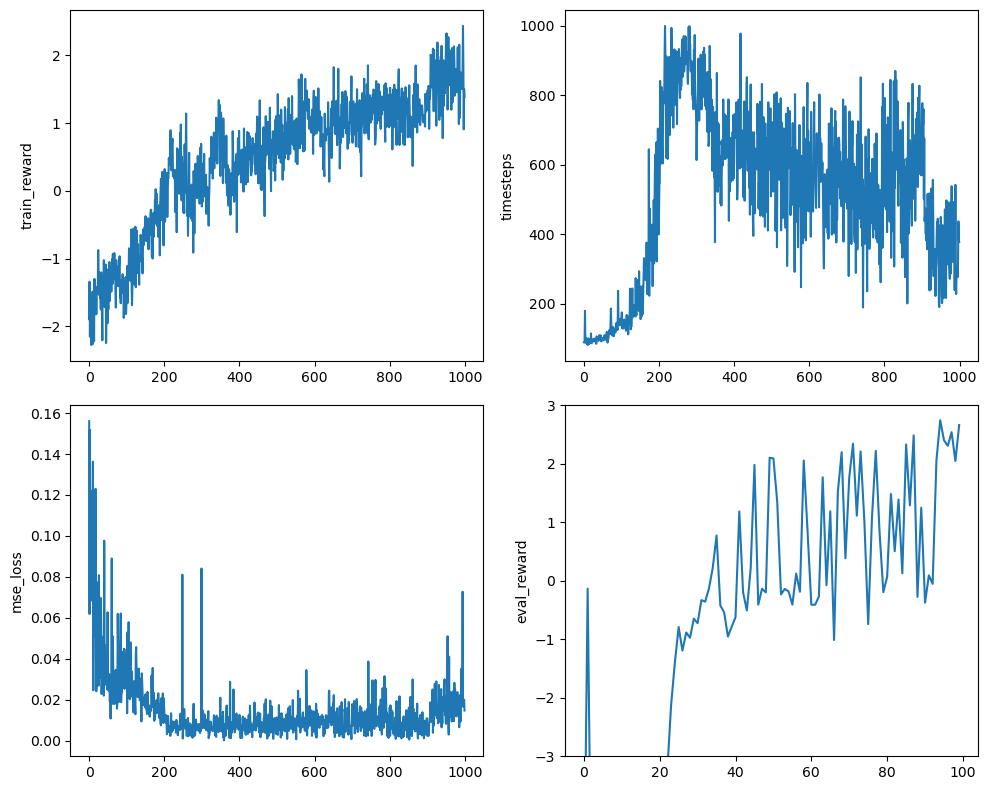

In [26]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env2.seed(iseed)
    
    # this is usually how you run it
    env_discrete = EnvWrapper(env2, reward_scale=0.01)
    policy_discrete = Policy(env_discrete, num_hidden=64)
    trainer = Trainer(env_discrete, policy_discrete)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards = trainer.train(n_epoches=1000, eval_everyepoch=10)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

In [27]:
# for _ in range(50):
#     trainer.agent.eval()
#     state = trainer.runner.env.reset()
#     rewards = 0
#     for _ in range(1000):
#         action, _, _ = trainer.agent.step(state)
#         state, reward, done, _ = trainer.runner.env.step(action)
#         rewards += reward
#         if done:  break
#     print(rewards)

In [28]:
# for _ in range(50):
#     trainer.agent.train()
#     state = trainer.runner.env.reset()
#     rewards = 0
#     for _ in range(1000):
#         action, _, _ = trainer.agent.step(state)
#         state, reward, done, _ = trainer.runner.env.step(action)
#         rewards += reward
#         if done:  break
#     print(rewards)

### for continuous but make to be discrete

train reward 2.675 trial steps 197.3 mse value loss 0.007 eval reward 0.933: 100


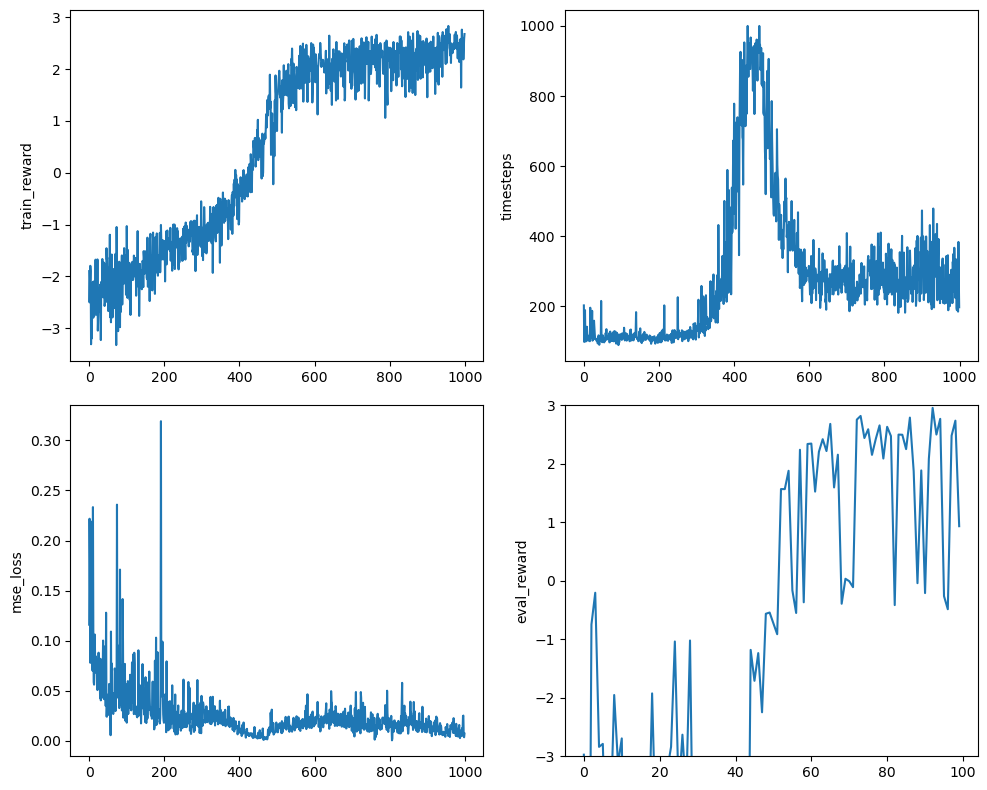

In [29]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env1.seed(iseed)
    
    # this is usually how you run it
    env_dis_continuous = EnvWrapper(env1, make_discrete=10, reward_scale=0.01)
    policy_dis_continuous = Policy(env_dis_continuous, num_hidden=64)
    trainer = Trainer(env_dis_continuous, policy_dis_continuous)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards = trainer.train(n_epoches=1000, eval_everyepoch=10)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

### for strictly continuous, we try init_logstd -2,-1,0 and also plot the std

train reward 1.235 trial steps 656.8 mse value loss 0.004 eval reward 1.732: 100


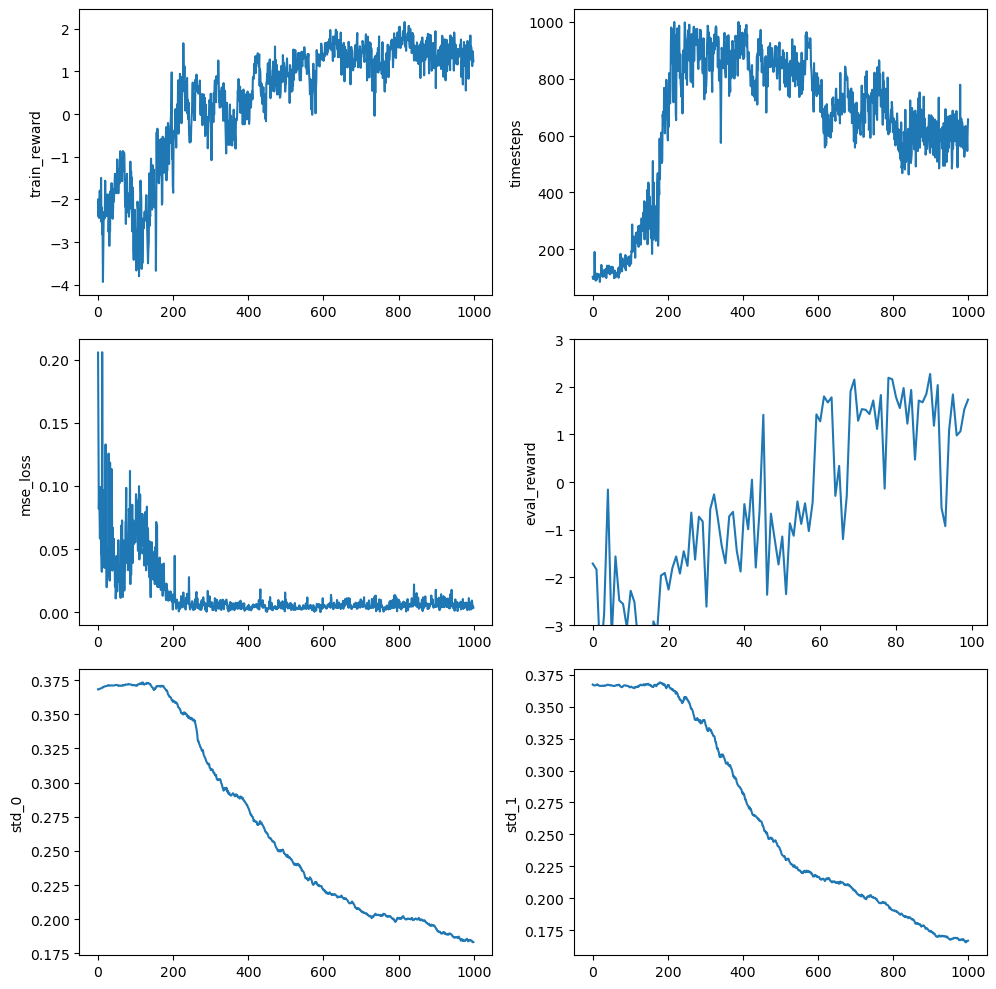

In [30]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env1.seed(iseed)
    
    # this is usually how you run it
    env_continuous = EnvWrapper(env1, reward_scale=0.01)
    policy_continuous = Policy(env_continuous, num_hidden=64, init_logstd=-1)
    trainer = Trainer(env_continuous, policy_continuous)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds = \
        trainer.train(n_epoches=1000, eval_everyepoch=10, keepstd=True)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds[:,0], output_stds[:,1]]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward', 'std_0', 'std_1']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

train reward -0.966 trial steps 156.5 mse value loss 0.024 eval reward -1.184: 1


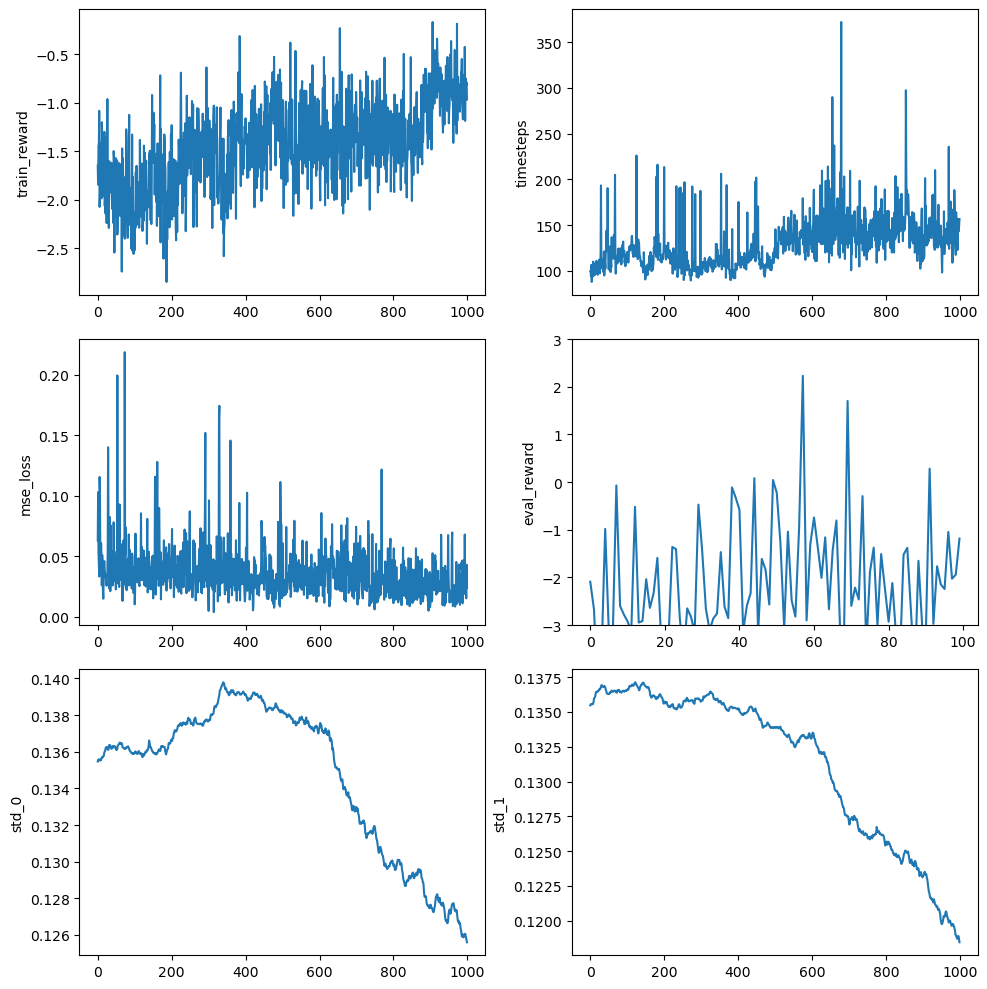

In [31]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env1.seed(iseed)
    
    # this is usually how you run it
    env_continuous = EnvWrapper(env1, reward_scale=0.01)
    policy_continuous = Policy(env_continuous, num_hidden=64, init_logstd=-2)
    trainer = Trainer(env_continuous, policy_continuous)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds = \
        trainer.train(n_epoches=1000, eval_everyepoch=10, keepstd=True)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds[:,0], output_stds[:,1]]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward', 'std_0', 'std_1']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

train reward 1.530 trial steps 622.8 mse value loss 0.004 eval reward 2.104: 100


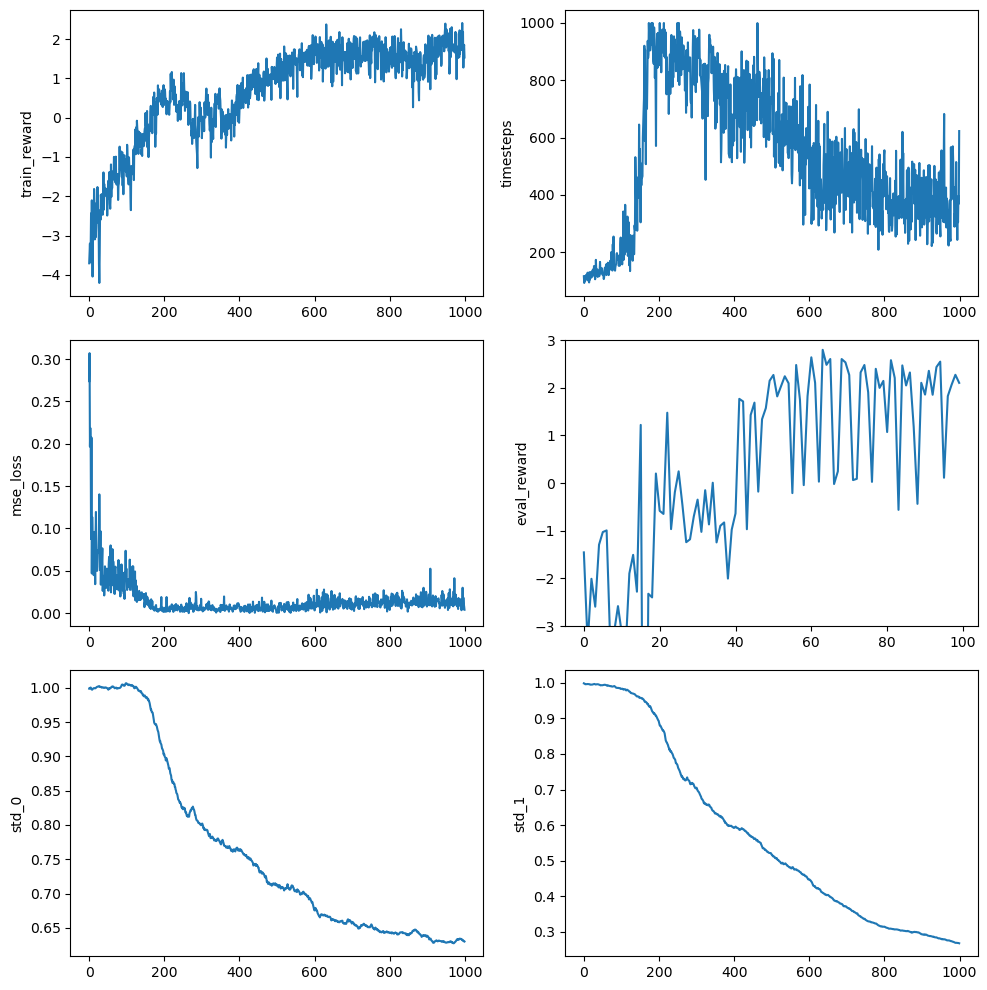

In [33]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env1.seed(iseed)
    
    # this is usually how you run it
    env_continuous = EnvWrapper(env1, reward_scale=0.01)
    policy_continuous = Policy(env_continuous, num_hidden=64, init_logstd=0)
    trainer = Trainer(env_continuous, policy_continuous)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds = \
        trainer.train(n_epoches=1000, eval_everyepoch=10, keepstd=True)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds[:,0], output_stds[:,1]]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward', 'std_0', 'std_1']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

### can I use larger step?

In [38]:
from tqdm import tqdm

train reward 2.303 trial steps 326.4 mse value loss 0.009 eval reward 2.768: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [50:52<00:00,  6.10s/it]


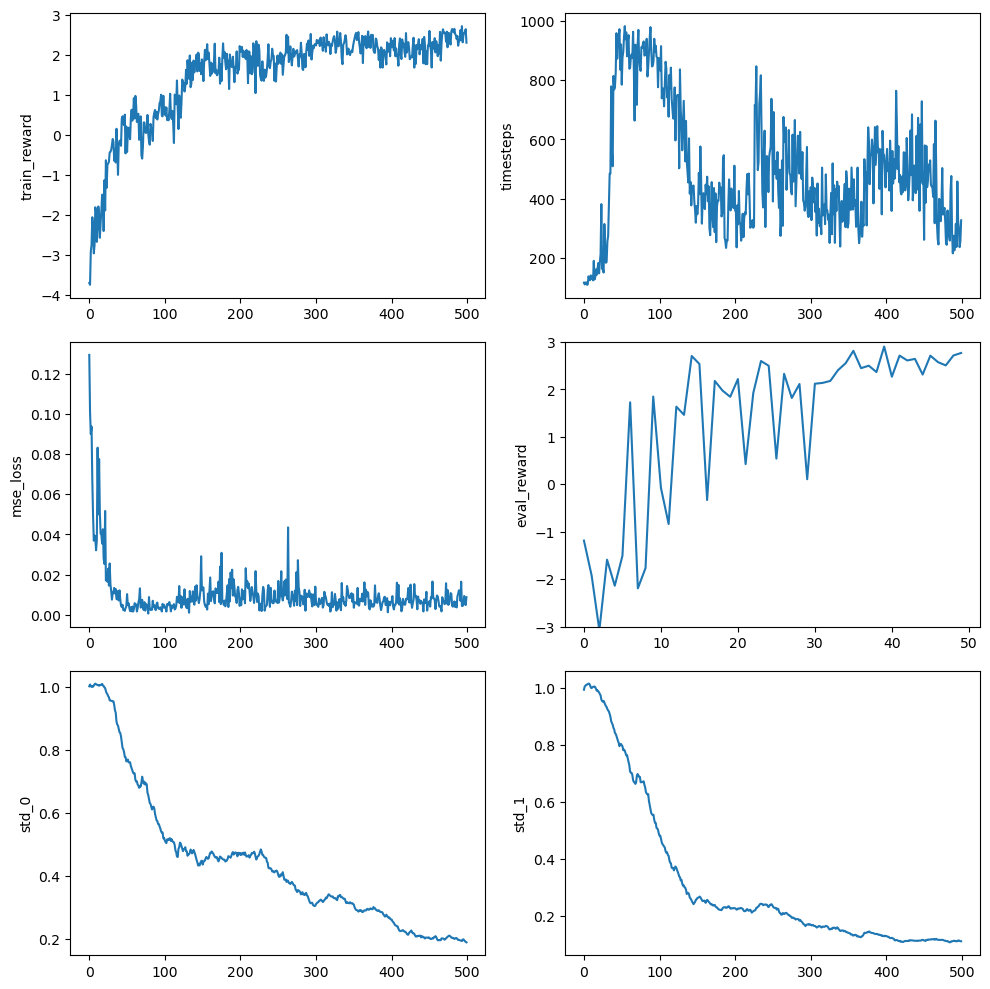

In [47]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env1.seed(iseed)
    
    # this is usually how you run it
    env_continuous = EnvWrapper(env1, reward_scale=0.01)
    policy_continuous = Policy(env_continuous, num_hidden=64, init_logstd=0)
    trainer = Trainer(env_continuous, policy_continuous, lr=1e-3)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds = \
        trainer.train(n_epoches=500, eval_everyepoch=10, keepstd=True)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds[:,0], output_stds[:,1]]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward', 'std_0', 'std_1']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

train reward -1.257 trial steps 71.6 mse value loss 0.012 eval reward -1.454: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [1:03:49<00:00,  7.66s/it]


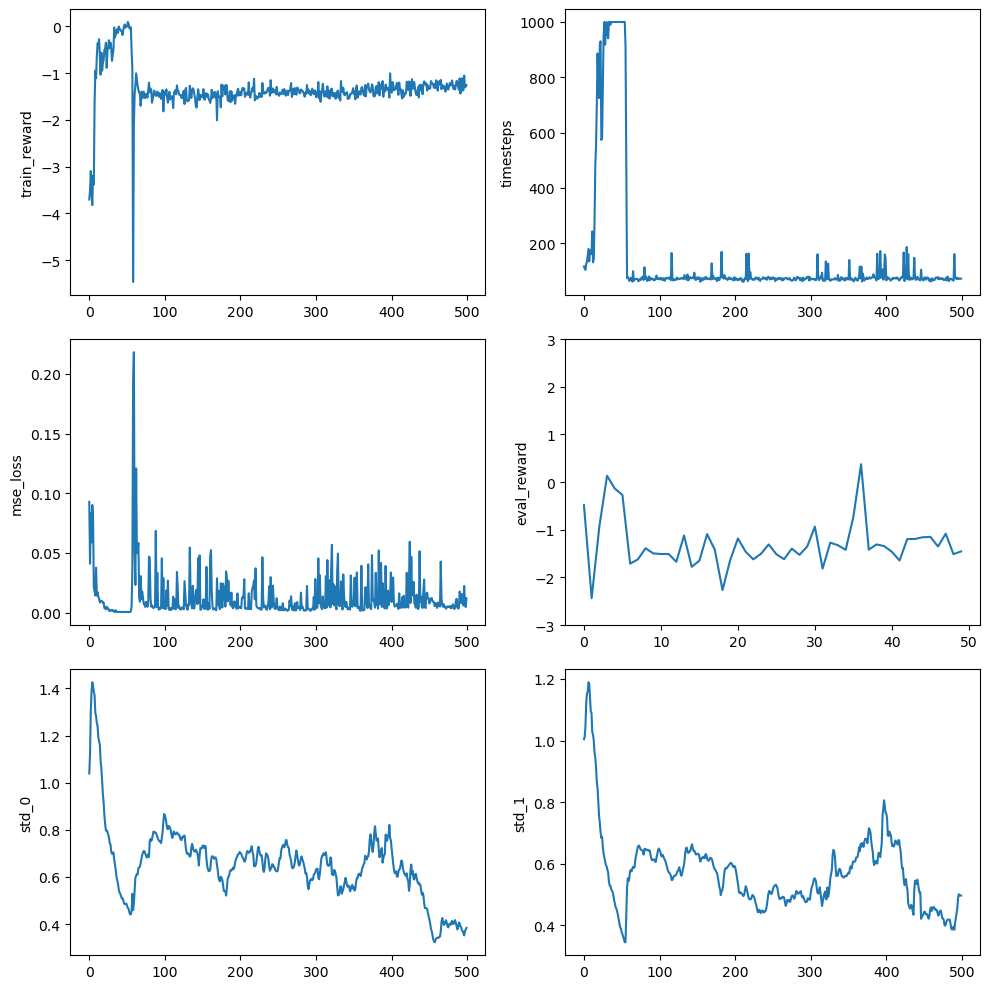

In [48]:
fig, axs = plt.subplots(3,2, figsize=(10,10))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env1.seed(iseed)
    
    # this is usually how you run it
    env_continuous = EnvWrapper(env1, reward_scale=0.01)
    policy_continuous = Policy(env_continuous, num_hidden=64, init_logstd=0)
    trainer = Trainer(env_continuous, policy_continuous, lr=1e-2)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds = \
        trainer.train(n_epoches=500, eval_everyepoch=10, keepstd=True)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards, output_stds[:,0], output_stds[:,1]]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward', 'std_0', 'std_1']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

### so looks like lr=1e-3, do 500 iterations would be good to go

### how about no critic?

train reward 2.115 trial steps 527.8 mse value loss 0.201 eval reward 1.888: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [49:17<00:00,  5.91s/it]


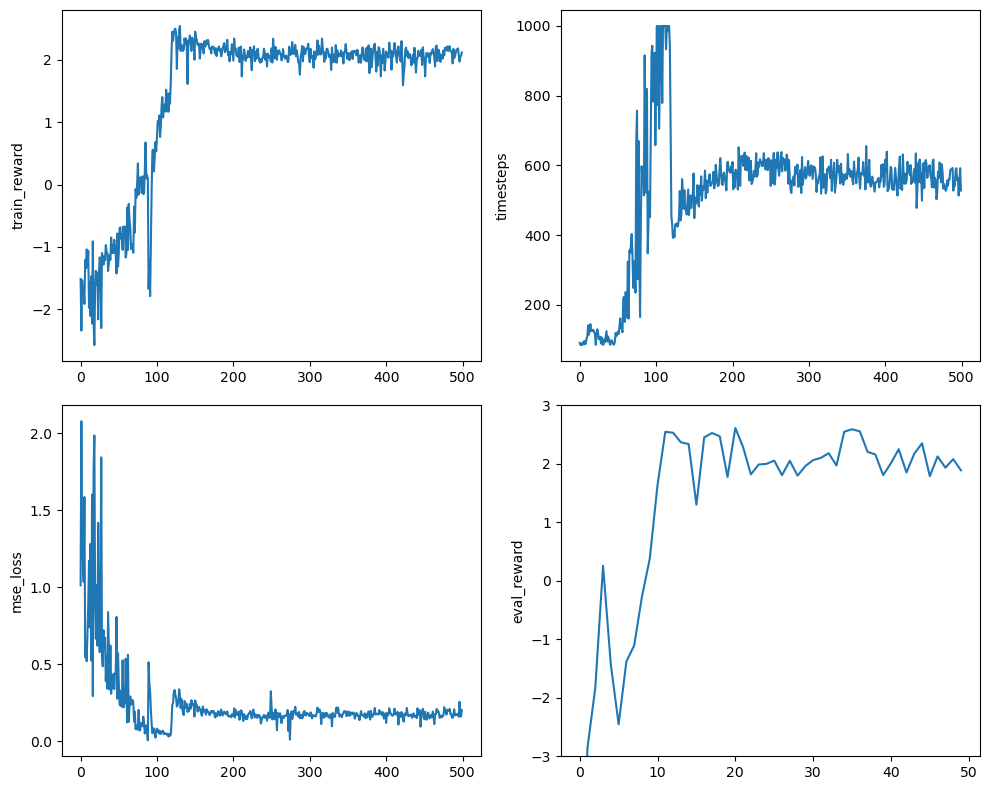

In [55]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
axs = axs.flatten()

# for seed in [1,2,3,4,5]:
for seed in [1]:
    
    # set the seeds
    iseed = seed
    np.random.seed(iseed)
    torch.random.manual_seed(iseed)
    env2.seed(iseed)
    
    # this is usually how you run it
    env_discrete = EnvWrapper(env2, reward_scale=0.01)
    policy_discrete = Policy(env_discrete, num_hidden=64, use_critic=False)
    trainer = Trainer(env_discrete, policy_discrete, lam=1.0, lr=1e-3)
    output_rewards, output_timesteps, output_mse_loss, eval_rewards \
      = trainer.train(n_epoches=500, eval_everyepoch=10)
    
    # make some plots
    outputs = [output_rewards, output_timesteps, output_mse_loss, eval_rewards]
    ylabels = ['train_reward', 'timesteps', 'mse_loss', 'eval_reward']
    for i, (arr, label) in enumerate(zip(outputs, ylabels)):
        axs[i].plot(arr)
        axs[i].set_ylabel(label)
        if label == 'eval_reward':
            axs[i].set_ylim([-3,3])
        
plt.tight_layout()

#### the bottom left can be treated as advantages in this case; This looks fine although it seems get stuck at a solution with higher number of steps.